# ARIMA / SARIMA алгоритмы для сезонных timescale данных

Рассмотрим датасет с потреблением электричества. Имеем колонку даты (*DATE*) и колонку с величиной потребления электричества (*IPG2211A2N*).

## Импортируем библиотеки

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd # работа с таблицами
import numpy as np # математические вычисления
from scipy import stats # статистические методы
import matplotlib
import matplotlib.pyplot as plt # визуализация данных
import seaborn as sns # визуализация данных


from statsmodels.tsa.seasonal import seasonal_decompose # оценка сезонности
from scipy.stats import normaltest # критерий Д'Агостино K^2, оценка данных на распределение Гаусса
from statsmodels.tsa.statespace.tools import diff  # разность рядов просто и/или сезонно вдоль нулевой оси
from statsmodels.tsa.arima.model import ARIMA # Построить модель ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX # Построить модель SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # plot_acf график автокорреляции, plot_pacf частичной автокорреляции
from statsmodels.graphics.tsaplots import month_plot,quarter_plot # график сезонности данных по месяцам, кварталам
from pandas.plotting import lag_plot # график лага

from statsmodels.tsa.stattools import adfuller # тест Дики-Фуллера

from sklearn.metrics import mean_squared_error, root_mean_squared_error # метрика качества MSE и RMSE
from statsmodels.tools.eval_measures import rmse  # метрика качества Квадратный корень из MSE

from sklearn.model_selection import train_test_split

from pmdarima import auto_arima # автоматический подбор параметров

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

In [2]:
plt.rcParams["figure.figsize"] = (10,5) # размер графиков

plt.style.use('fivethirtyeight') # стиль графиков

In [3]:
def adf_test(series,title=''):
  '''
  тест Дики-Фуллера
  0 гипотеза: ряд данных не стационарен
  альтернативная гипотеза: ряд данных стационарен
  Понятие стационарного временного ряда означает, что его среднее значение не изменяется во времени, т. е. временной ряд не имеет тренда
  @param series - значения ряда
  @param title - заголовок ряда
  '''

  result = adfuller(series.dropna(),autolag='AIC') # тест предполагает линейный тренд

  labels = ['ADF тест','p-value','# lags used','# наблюдения']
  out = pd.Series(result[0:4],index=labels)

  for key,val in result[4].items():
      out[f'критическое значение ({key})']=val

  print(out.to_string())

  if result[1] <= 0.05:
      print("Сильные доказательства против нулевой гипотезы")
      print("Отменяем 0 гипотезу")
      print("Данные стационарны")
  else:
      print("Слабые доказательства против нулевой гипотезы")
      print("Не отменяем 0 гипотезу")
      print("Данные не стационарны")

## Загрузим датасет и проведем EDA

In [4]:
# загрузка данных
# index_col="time" (колонка индекс)
# parse_dates= True
df= pd.read_csv(
    "electric-production.csv",
    index_col="DATE", parse_dates=True
    ) #datetime

df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   IPG2211A2N  397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


In [6]:
df.describe()

,IPG2211A2N
count,397.000000
mean,88.847218
std,15.387834
min,55.315100
25%,77.105200
50%,89.779500
75%,100.524400
max,129.404800


In [7]:
df.index

DatetimeIndex(['1985-01-01', '1985-02-01', '1985-03-01', '1985-04-01',
               '1985-05-01', '1985-06-01', '1985-07-01', '1985-08-01',
               '1985-09-01', '1985-10-01',
               ...
               '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
               '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01',
               '2017-12-01', '2018-01-01'],
              dtype='datetime64[ns]', name='DATE', length=397, freq=None)

In [8]:
# Проверка распределения даты по порядку
df.index.is_monotonic_increasing

True

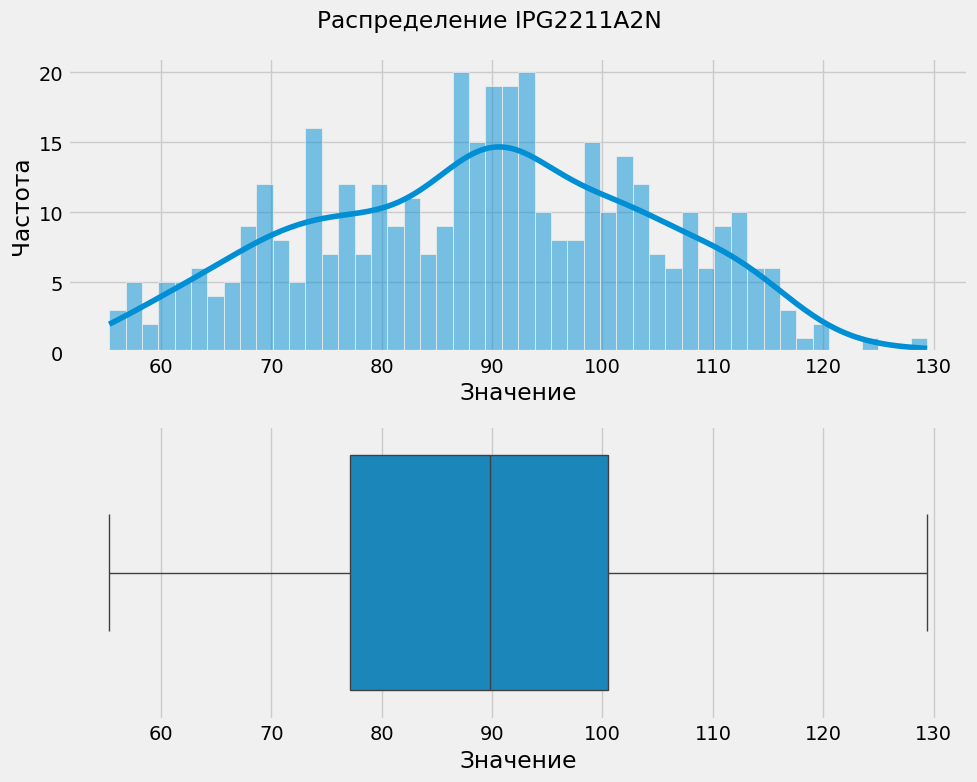

In [9]:
# Распределение показателей потребления электричества
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

sns.histplot(df['IPG2211A2N'], bins=50, kde=True, ax=ax[0])
ax[0].set_xlabel("Значение")
ax[0].set_ylabel("Частота")

sns.boxplot(df['IPG2211A2N'], orient="h", ax=ax[1])
ax[1].set_xlabel("Значение")
ax[1].set_yticks([])

plt.suptitle("Распределение IPG2211A2N")
plt.tight_layout()
plt.show()

**Вывод: данные в хорошем состоянии, пропусков в данных нет, выбросов тоже нет. Дата вынесена в индекс датасета. Данные представлены с января 1985 года по январь 2018 года (всего 33 года).**

## Проведем анализ временного ряда

### Скользящее окно

Чтобы во временном ряду снизить колебания, применим скользящее среднее. **Скользящее среднее (rolling mean)** — метод сглаживания временных рядов. Его суть заключается в поиске значений, которые меньше всего подвержены колебаниям, то есть средних арифметических.

Метод работает так: экспериментально подбирается размер окна (англ. window size) — интервал, в котором выполняют усреднение. Чем интервал больше, тем сильнее сглаживание. Примем размер окна равным 12.

Также построим скользящее со стандартным отклонением (rolling std).

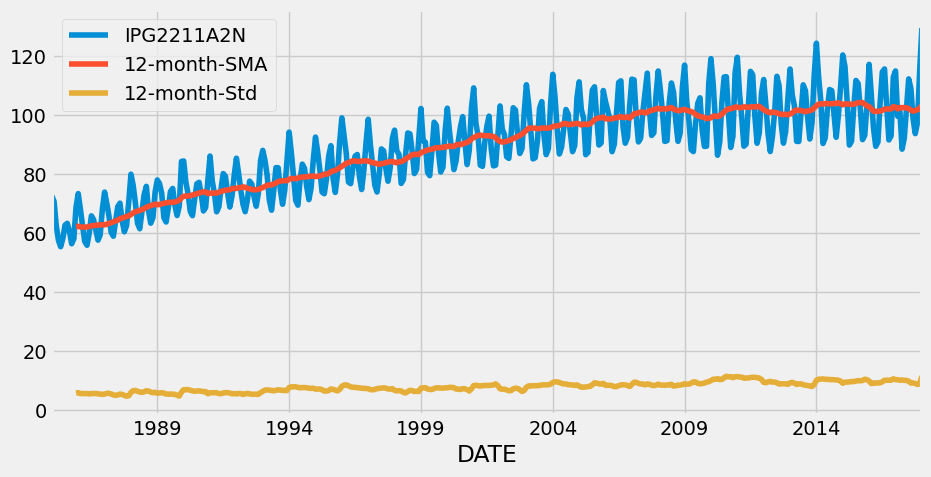

In [10]:
# дескриптивная аналитики, расчеты скользящего окна
df['12-month-SMA'] = df['IPG2211A2N'].rolling(window=12).mean()
df['12-month-Std'] = df['IPG2211A2N'].rolling(window=12).std()

df[['IPG2211A2N','12-month-SMA','12-month-Std']].plot();

### Сезонность

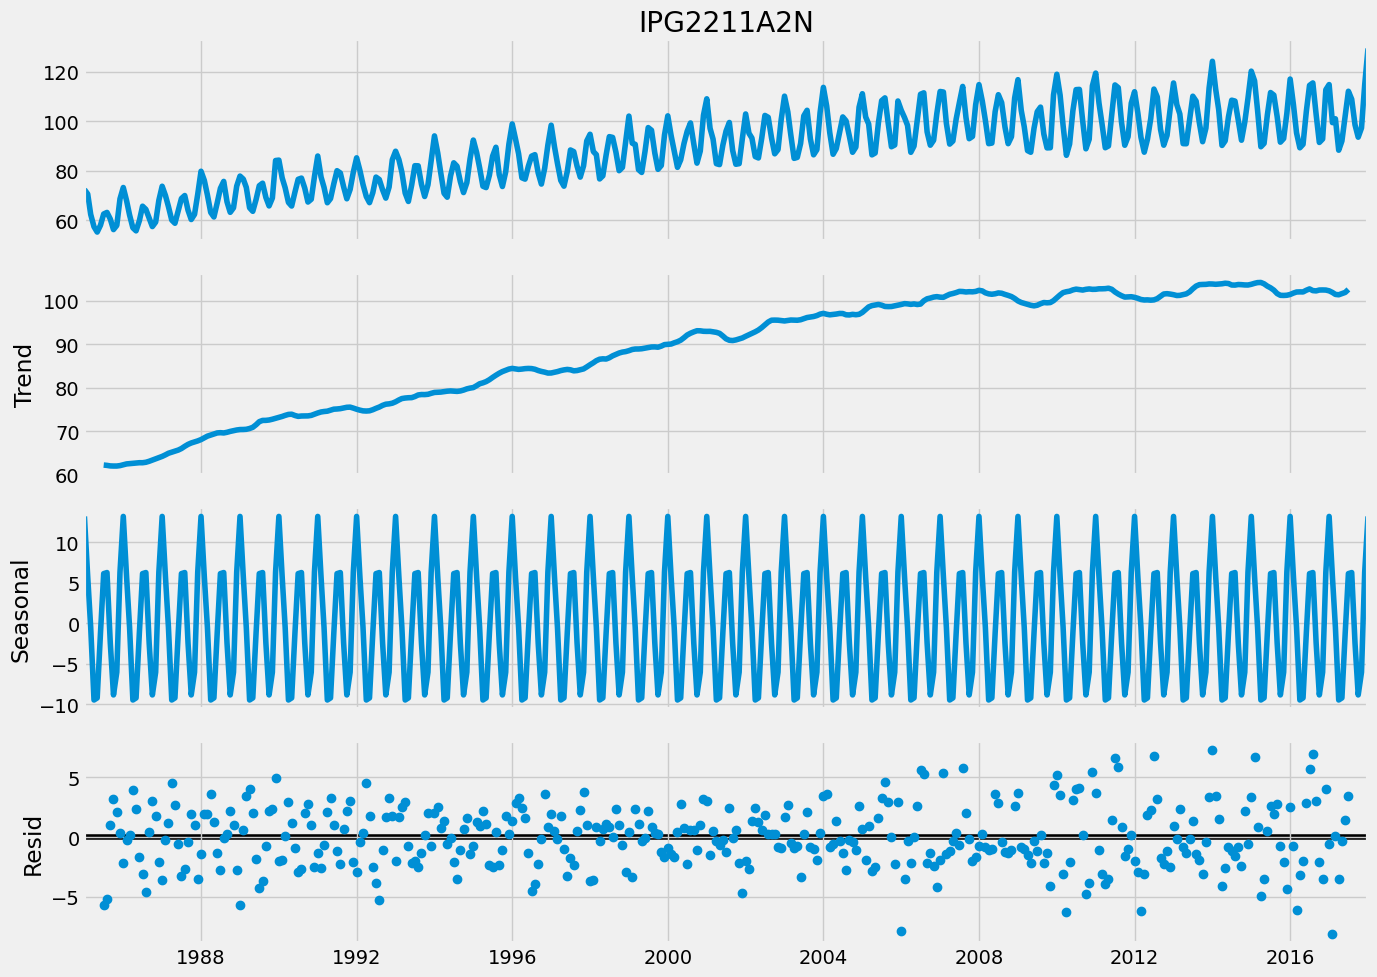

In [11]:
# сезонная декомпозиция
ssn= seasonal_decompose(df["IPG2211A2N"], model="add")
fig = ssn.plot()
fig.set_size_inches((14, 10))
fig.tight_layout()
plt.show()

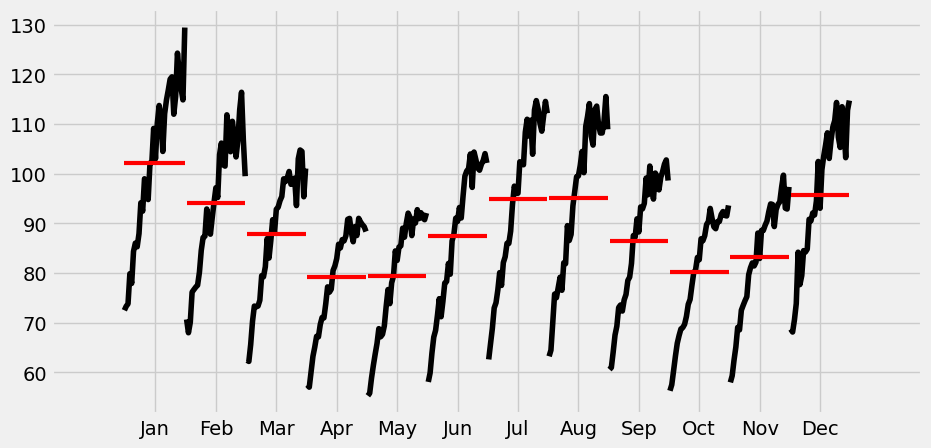

In [12]:
# построим новый вид графика
month_plot(df['IPG2211A2N']);

**Тренд (англ. trend)** — плавное изменение среднего значения ряда без повторяющихся закономерностей.

**Сезонность (англ. seasonality)** — циклично повторяющиеся закономерности во временном ряду.

**Остаток (англ. residuals)** - это компонента, которая не объясняется трендом и сезонностью, это шум.

В наших данных присутствует определенная сезонность и тренд.

### Автокорреляция и частичная автокорреляция

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

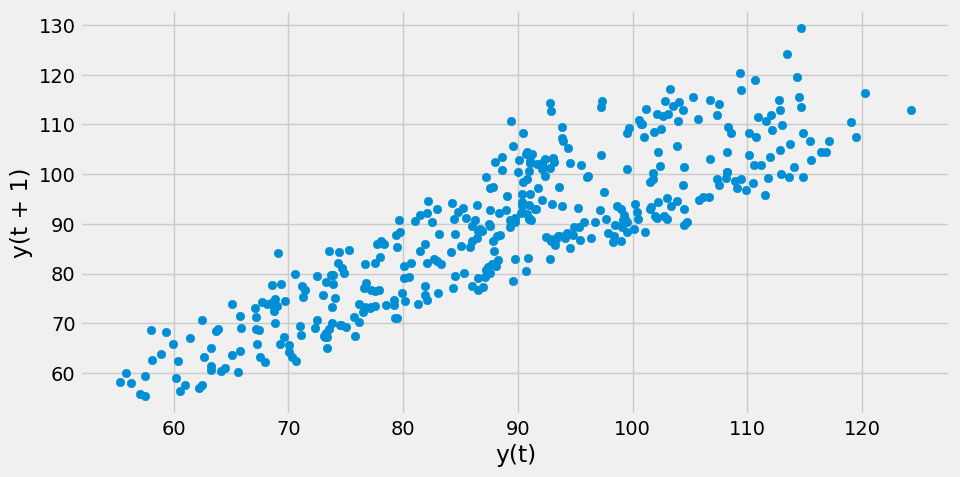

In [13]:
# автокорреляция значения t+1 (следующий лаг времени) от текущего (t)
lag_plot(df['IPG2211A2N'])

Видим хорошую корреляцию в данных

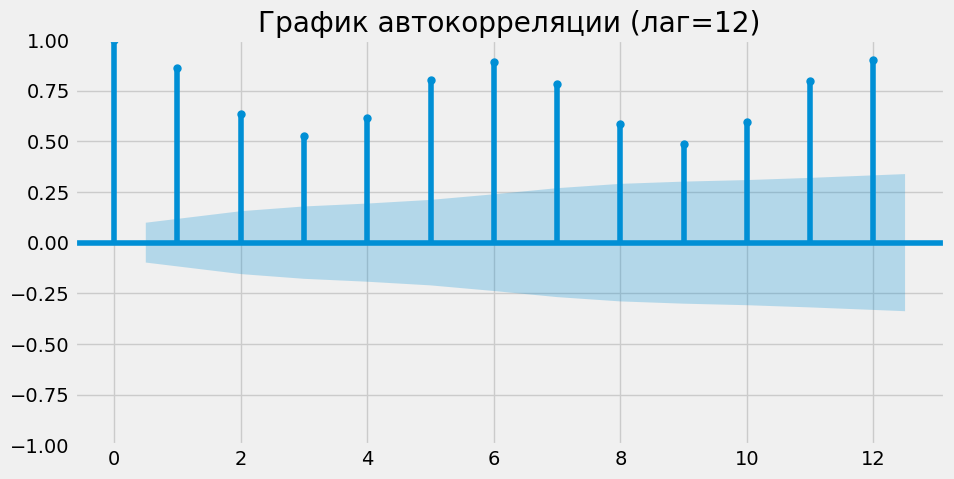

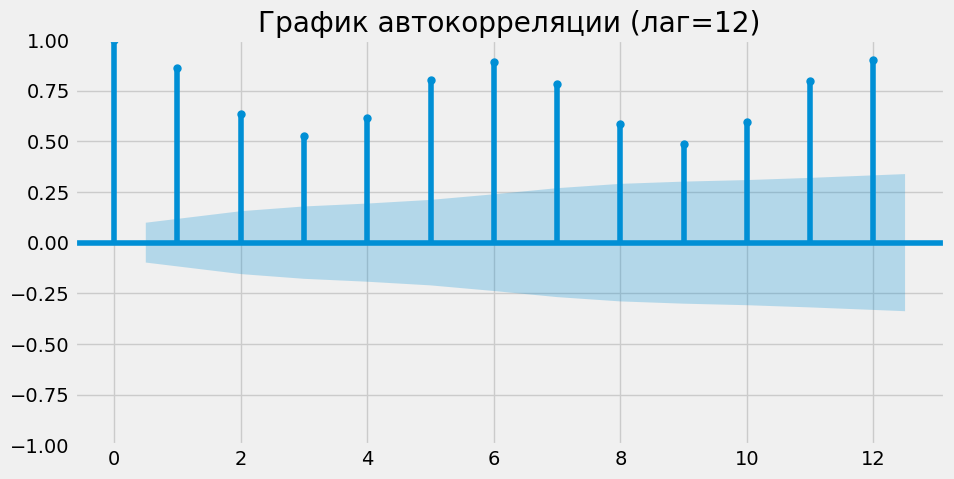

In [14]:
# ACF - Автокорреляция
title = 'График автокорреляции (лаг=12)'
lags = 12 # оптимальное значение (т.к. большой временной период)
plot_acf(df["IPG2211A2N"],title=title,lags=lags)

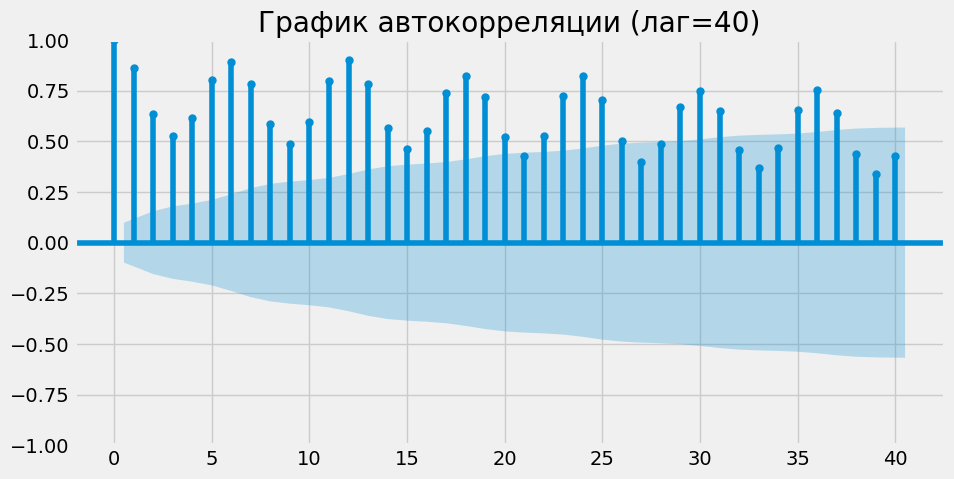

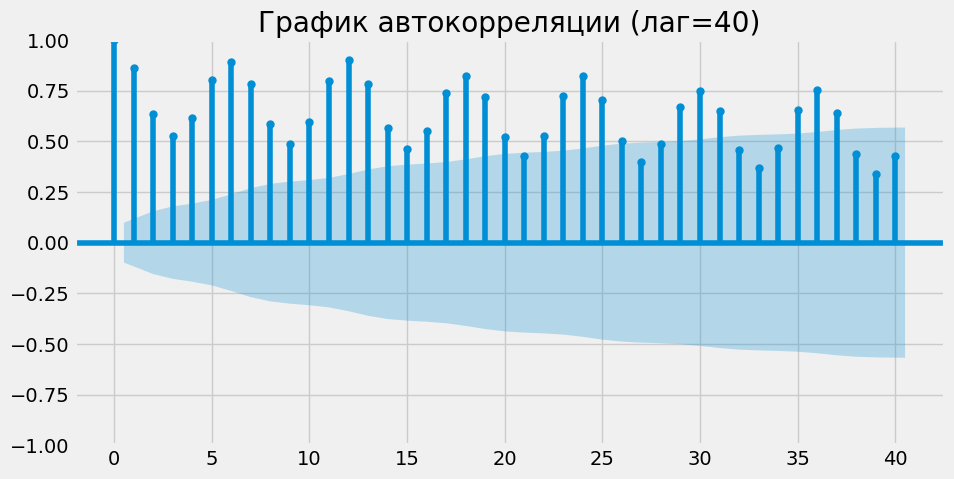

In [15]:
# ACF проверка при значении лагов 40 (по умолчанию)
title = 'График автокорреляции (лаг=40)'
lags = 40 
plot_acf(df["IPG2211A2N"],title=title,lags=lags)

Доверительные интервалы изображены в виде полупрозрачного голубого конуса. 

По умолчанию установлен доверительный интервал **alpha= 100% -95%**. Если голубая точка лежит за пределами этой фигуры, то является статистически значимой единицей. 

Видим что при значении лага 12 все точки лежат за пределами купола, а при 40 уже нет.

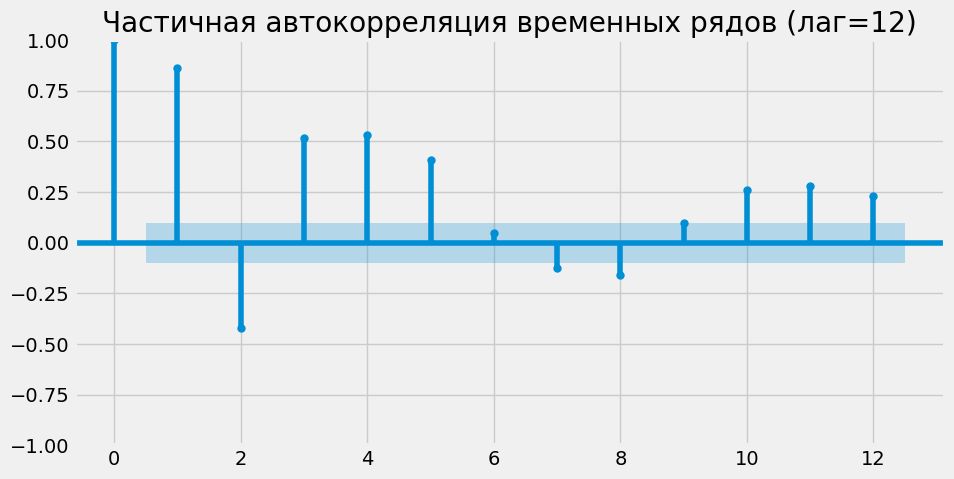

In [16]:
# PACF - функция частичной автокорреляции дает частичную корреляцию стационарного временного ряда с его собственными запаздывающими значениями
title = 'Частичная автокорреляция временных рядов (лаг=12)'
lags = 12
plot_pacf(df["IPG2211A2N"],title=title,lags=lags);

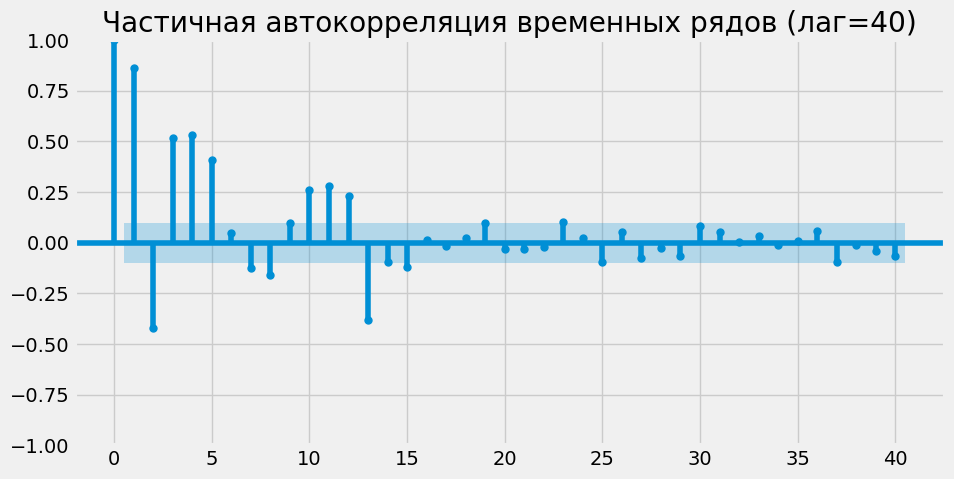

In [17]:
# PACF проверка с лагом 40
title = 'Частичная автокорреляция временных рядов (лаг=40)'
lags = 40
plot_pacf(df["IPG2211A2N"],title=title,lags=lags);

**Частичная автокорреляция (PartialAutocorrelation–PACF)** – это сводка отношений между наблюдением во временном ряду с наблюдениями на предыдущих временных шагах с удаленными взаимосвязями промежуточных наблюдений.

Видим, что с лагом 12 значения также не попадают в доверительный интервал. Делаем вывод, что лаг = 12 верен и его можно использовать.

### Стационарность

In [18]:
# тест на стационарность, p-value < 0.05
adf_test(df["IPG2211A2N"])

ADF тест                       -2.256990
p-value                         0.186215
# lags used                    15.000000
# наблюдения                  381.000000
критическое значение (1%)      -3.447631
критическое значение (5%)      -2.869156
критическое значение (10%)     -2.570827
Слабые доказательства против нулевой гипотезы
Не отменяем 0 гипотезу
Данные не стационарны


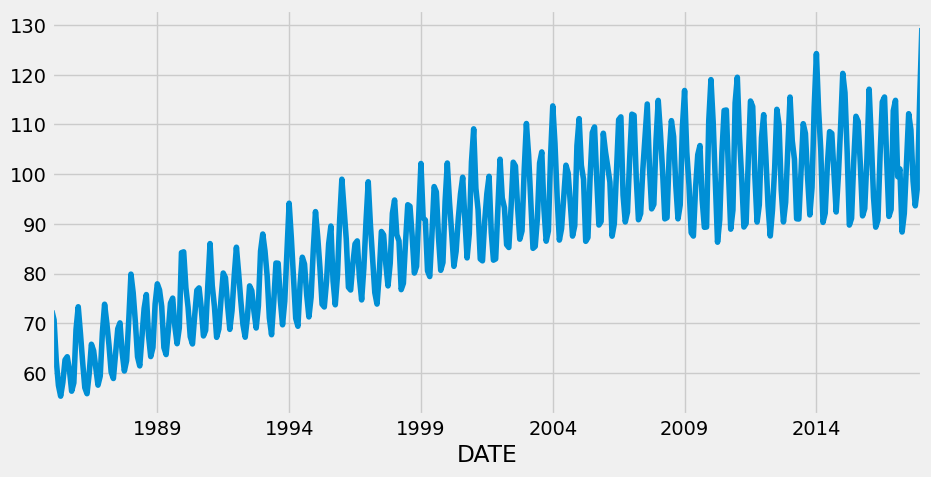

In [19]:
df["IPG2211A2N"].plot();

Видим, что данные не стационарны. Сконвертируем нестационарный ряд в стационарный. Понятие стационарного временного ряда означает, что его среднее значение не изменяется во времени, т. е. временной ряд не имеет тренда.

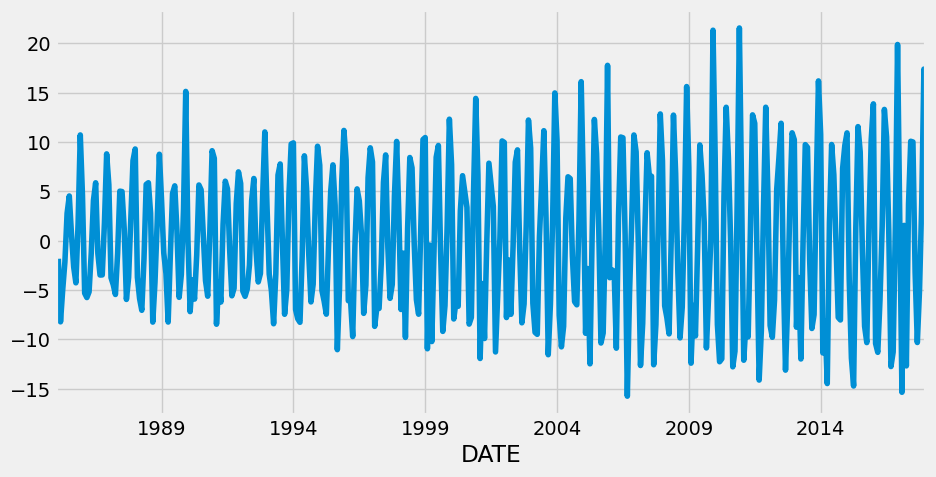

In [20]:
df["difference_1"]= diff(df["IPG2211A2N"], k_diff=1)
df["difference_1"].plot();

In [21]:
adf_test(df["difference_1"])

ADF тест                     -7.104891e+00
p-value                       4.077787e-10
# lags used                   1.400000e+01
# наблюдения                  3.810000e+02
критическое значение (1%)    -3.447631e+00
критическое значение (5%)    -2.869156e+00
критическое значение (10%)   -2.570827e+00
Сильные доказательства против нулевой гипотезы
Отменяем 0 гипотезу
Данные стационарны


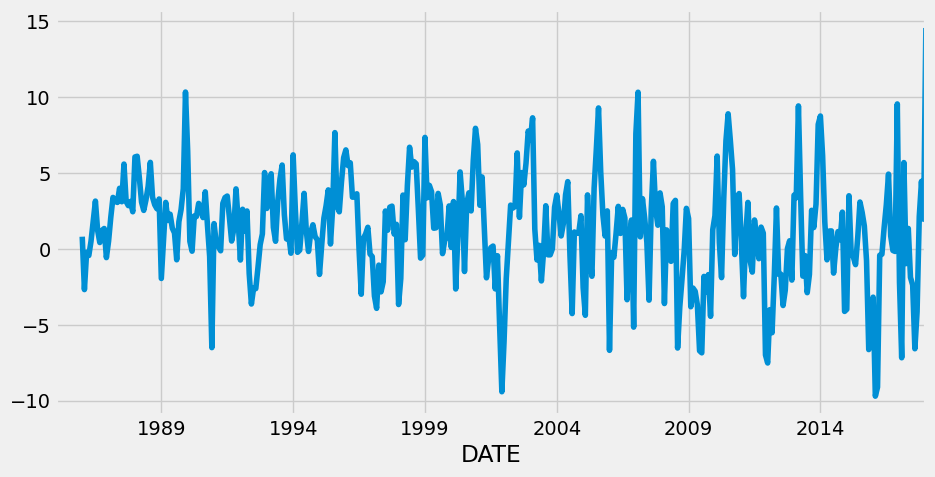

In [22]:
# стационарность после сезонной разности
df["difference_seasonal"]= diff(df["IPG2211A2N"], k_diff=0,k_seasonal_diff= 1,seasonal_periods= 12)
df["difference_seasonal"].plot();

In [23]:
adf_test(df["difference_seasonal"])

ADF тест                     -5.673482e+00
p-value                       8.812645e-07
# lags used                   1.200000e+01
# наблюдения                  3.720000e+02
критическое значение (1%)    -3.448052e+00
критическое значение (5%)    -2.869341e+00
критическое значение (10%)   -2.570926e+00
Сильные доказательства против нулевой гипотезы
Отменяем 0 гипотезу
Данные стационарны


Видим, что оба способа помогли сконвертировать данные из нестационарных в стационарные.

## Разделим данные на выборки

In [24]:
# Выделяем тестовую выборку
train, test = train_test_split(df,
                               test_size=0.2,
                               shuffle=False, 
                               random_state=42)
print('Размер тренировочной выборки:', train.shape)
print('Размер тестовой выборки:', test.shape)

Размер тренировочной выборки: (317, 5)
Размер тестовой выборки: (80, 5)


In [25]:
train.head(15)

,IPG2211A2N,12-month-SMA,12-month-Std,difference_1,difference_seasonal
DATE,,,,,
1985-01-01,72.5052,NaN,NaN,NaN,NaN
1985-02-01,70.6720,NaN,NaN,-1.8332,NaN
1985-03-01,62.4502,NaN,NaN,-8.2218,NaN
1985-04-01,57.4714,NaN,NaN,-4.9788,NaN
1985-05-01,55.3151,NaN,NaN,-2.1563,NaN
1985-06-01,58.0904,NaN,NaN,2.7753,NaN
1985-07-01,62.6202,NaN,NaN,4.5298,NaN
1985-08-01,63.2485,NaN,NaN,0.6283,NaN
1985-09-01,60.5846,NaN,NaN,-2.6639,NaN


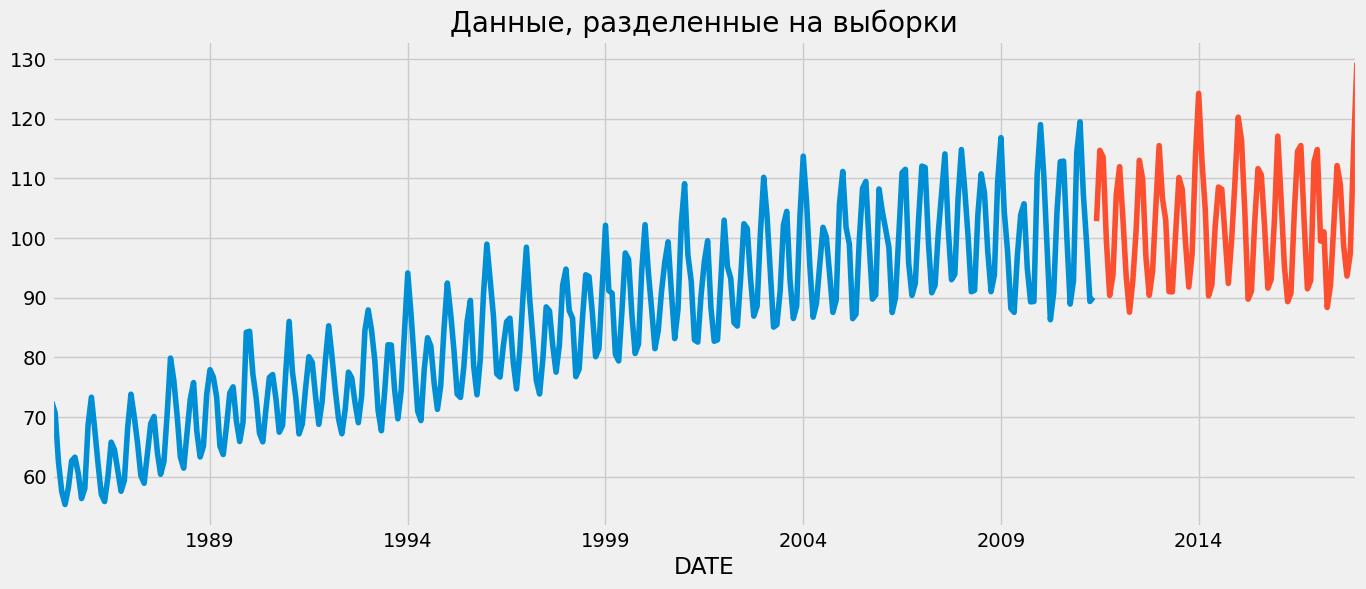

In [26]:
plt.figure(figsize=(15, 6))
plt.title('Данные, разделенные на выборки')

train['IPG2211A2N'].plot()
test['IPG2211A2N'].plot()

plt.show()

In [27]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

1985-01-01 00:00:00 2011-05-01 00:00:00
2011-06-01 00:00:00 2018-01-01 00:00:00


Видим, что порядок не нарушен, утечки данных нет.

Удалим все пропуски Nan, которые получились в тренировочной выборке из-за лага=12.

In [28]:
train = train.dropna()

In [29]:
print('Размер тренировочной выборки:', train.shape)
print('Размер тестовой выборки:', test.shape)

Размер тренировочной выборки: (305, 5)
Размер тестовой выборки: (80, 5)


## Автоматический подбор параметров (ARIMA/SARIMA модели)

### ARIMA модель

ARIMA представляет собой комбинацию трех моделей:

- AR (p) Авторегрессия - модель авторегрессии, которая использует зависимость между текущим наблюдением и наблюдениями за предыдущий период или периоды.
- I (d) Интеграция - использует разность наблюдений, чтобы сделать временной ряд стационарным.
- MA (q) MovingAverage - модель, которая использует зависимость между наблюдением и остаточной ошибкой из модели скользящего среднего, применяемой к запаздывающим наблюдениям.

**ARIMA: AR(p)+I(d)+MA(q) = ARIMA(p,d,q)**


In [30]:
# найдем порядок p,d,q
# ARIMA: обучение модели без сезонной составляющей (seasonal=False)
auto_arima_results= auto_arima(train["IPG2211A2N"],
           start_p=0,
           start_q=0,
           max_p=5,
           max_q=5,
           m=1,
           d=None,
           seasonal=False,
           start_P=0,
           D=0,
           trace=True,
           error_action='ignore',
           stepwise=True)

auto_arima_results.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2077.188, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2034.273, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1981.169, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2075.205, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1982.867, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1898.125, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1912.925, Time=0.04 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.005 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  305
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -945.062
Date:                Sun, 30 Mar 2025   AIC                           1898.125
Time:                        23:50:49   BIC                           1912.993
Sample:                    01-01-1986   HQIC                          1904.072
                         - 05-01-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1319      0.012     11.329      0.000       0.109       0.155
ma.L1         -0.1969      0.037     -5.290      0.000      -0.270      -0.124
ma.L2         -0.7743      0.044    -17.449      0.000      -0.861      -0.687
sigma2        29.0460      2.595     11.191      0.000      23.959      34.133
===================================================================================
Ljung-Box (L1) (Q):                  17.53   Jarque-Bera (JB):                 1.97
Prob(Q):                              0.00   Prob(JB):                         0.37
Heteroskedasticity (H):               2.37   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

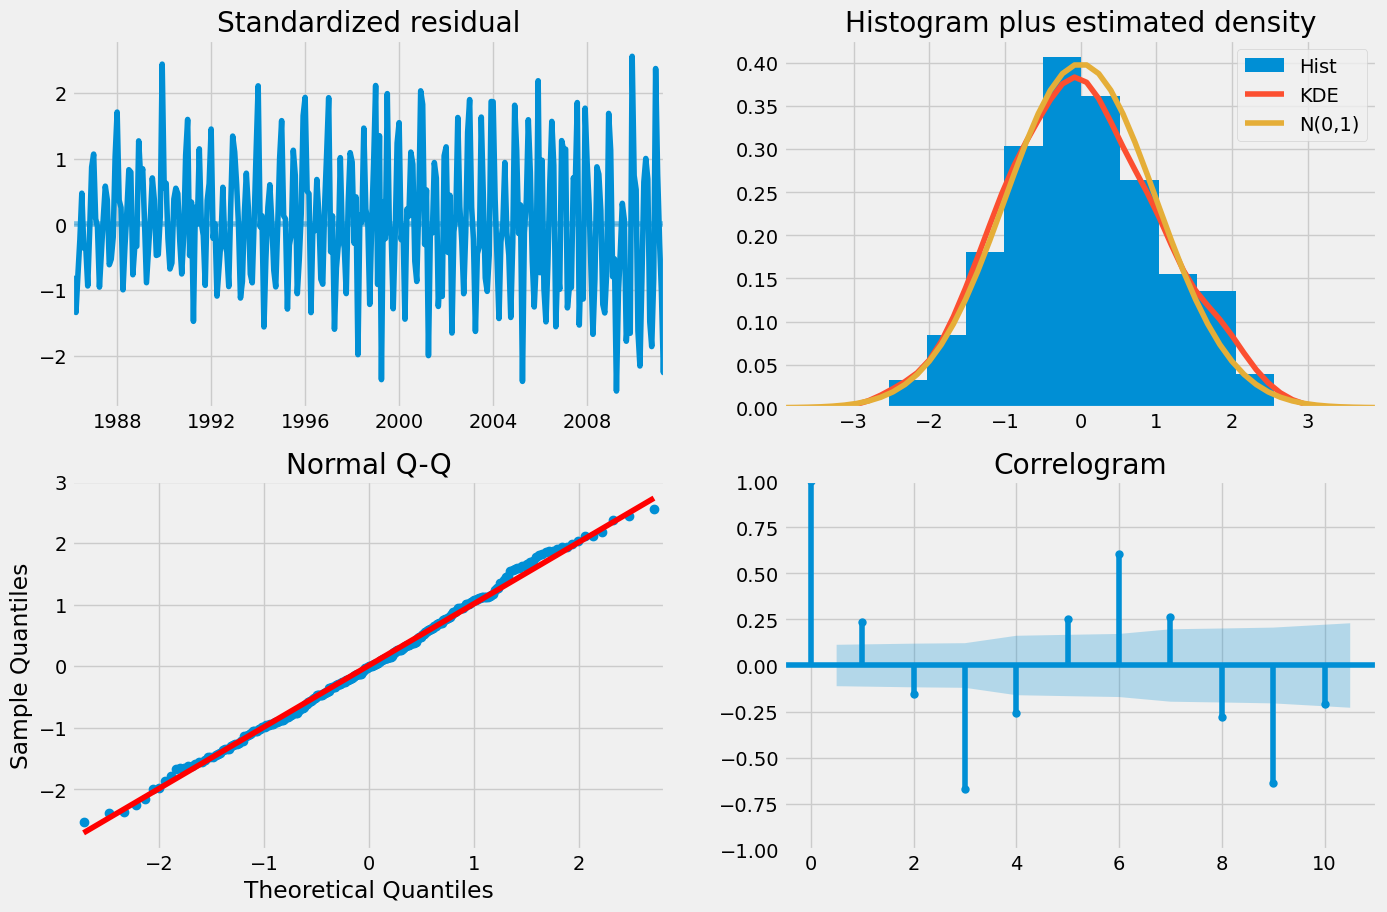

In [31]:
# интерпретация ARIMA модели в виде графиков
auto_arima_results.plot_diagnostics(figsize=(15,10))
plt.show()

In [32]:
# обучим модель ARIMA используя p,d,q из полученного результата по auto_arima. Best model: ARIMA(0,1,2)(0,0,0)[0] intercept
arima_model= ARIMA(train["IPG2211A2N"], order= (0,1,2), freq=train.index.inferred_freq)
arima_model_fit= arima_model.fit()

c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [33]:
normaltest(arima_model_fit.resid)
# если p-value не менее 0.05 , это означает, что остатки нормально распределены

NormaltestResult(statistic=302.7820187776151, pvalue=1.7853362070771614e-66)

In [34]:
# сделаем прогноз на test наборе данных
start = len(train)
end = len(train) + len(test) -1

pred_arima = arima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("ARIMA predictions")

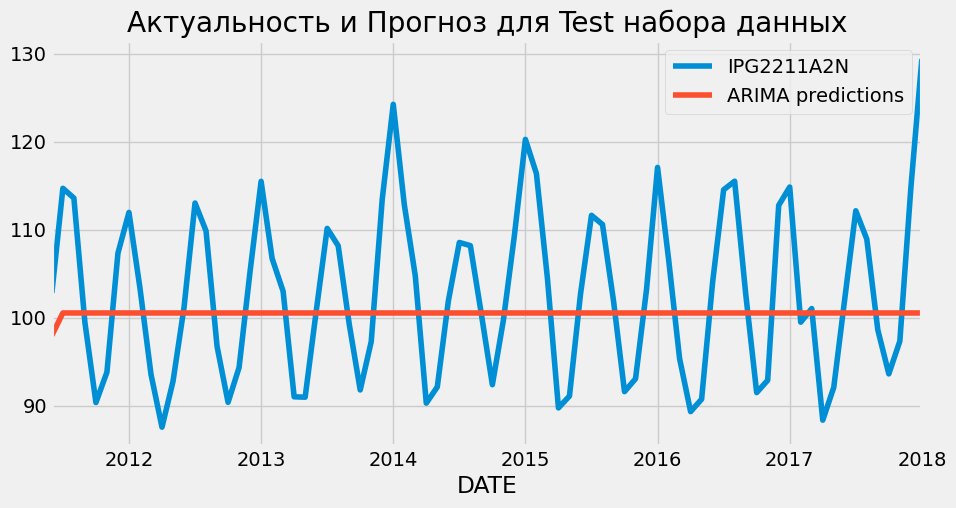

In [35]:
title= "Актуальность и Прогноз для Test набора данных"
test["IPG2211A2N"].plot(title= title, legend=True);
pred_arima.plot(legend=True);

Видим, что модель совсем плохо предсказывает на тестовых данных. Посмотрим подробнее, какой из элементов - AR (Авторегрессия), I (Интеграция) или MA (MovingAverage) перетягивает на себя одеяло.

In [36]:
# Построение модели I (d)
p = 0
d = 1
q = 2
model_d = ARIMA(train['IPG2211A2N'], order=(0,d,0))
results_d_fit = model_d.fit()

c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


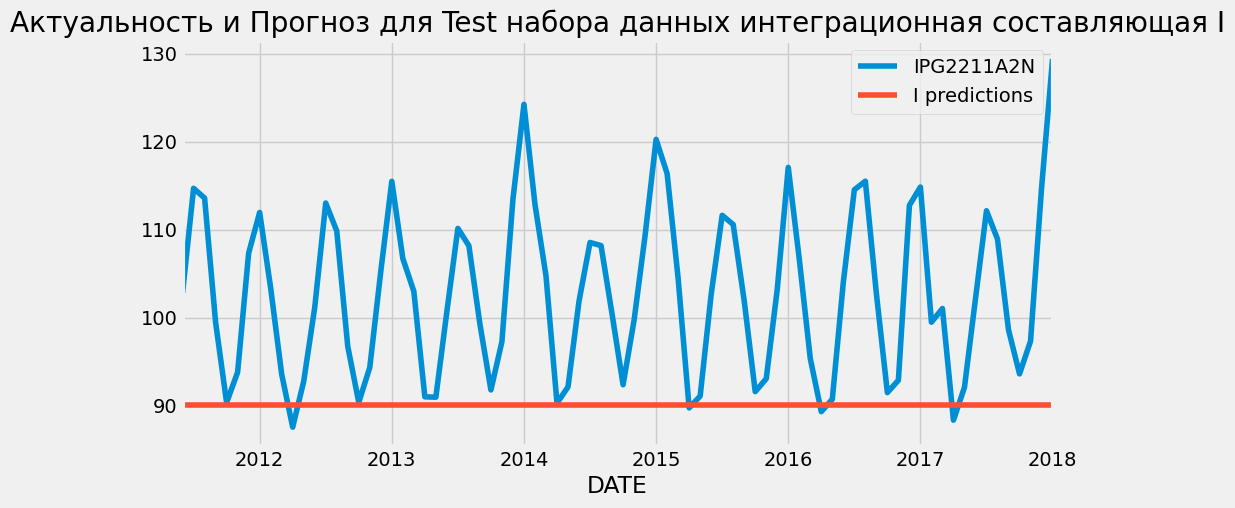

In [37]:
pred_results_d = results_d_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("I predictions")
title= "Актуальность и Прогноз для Test набора данных интеграционная составляющая I"
test["IPG2211A2N"].plot(title= title, legend=True);
pred_results_d.plot(legend=True);

In [38]:
# Построение модели AR (p)
p = 0
d = 1
q = 2
model_ar = ARIMA(train['IPG2211A2N'], order=(p,0,0))
results_ar_fit = model_ar.fit()

c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


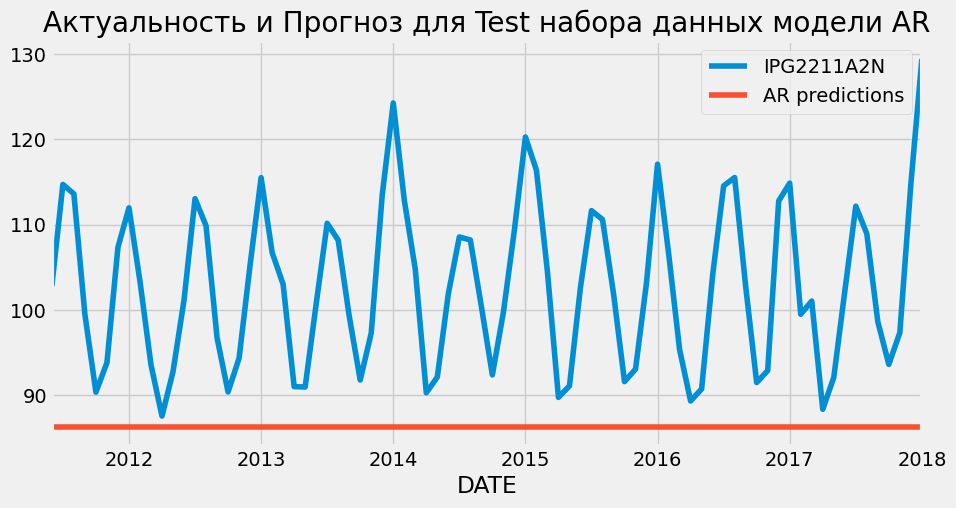

In [39]:
pred_results_ar = results_ar_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("AR predictions")
title= "Актуальность и Прогноз для Test набора данных модели AR"
test["IPG2211A2N"].plot(title= title, legend=True);
pred_results_ar.plot(legend=True);

In [40]:
# Построение модели MA (q)
p = 0
d = 1
q = 2
model_ma = ARIMA(df['IPG2211A2N'], order=(0,0,q))
results_ma_fit = model_ma.fit()

c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


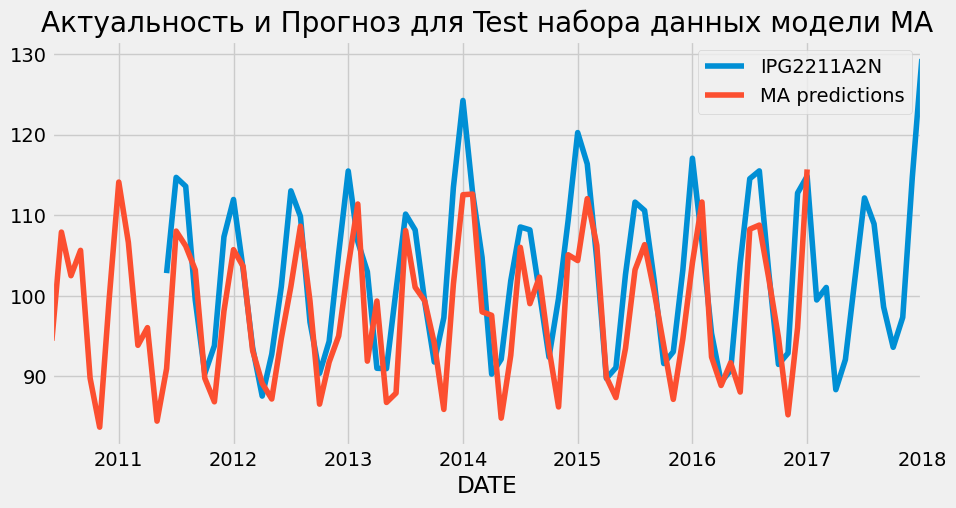

In [41]:
pred_results_ma = results_ma_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("MA predictions")
title= "Актуальность и Прогноз для Test набора данных модели MA"
test["IPG2211A2N"].plot(title= title, legend=True);
pred_results_ma.plot(legend=True);

In [42]:
# оценим модель по штрафным баллам
mse_arima= mean_squared_error(test["IPG2211A2N"],pred_arima)
rmse_arima= rmse(test["IPG2211A2N"], pred_arima)

print(f"RMSE_ARIMA= {rmse_arima}")
print(f"MSE_ARIMA= {mse_arima}")

RMSE_ARIMA= 9.822132362506778
MSE_ARIMA= 96.47428414660298


### SARIMA модель

Модель учитывает сезонность (**Seasonality, S**)


In [43]:
# найдем порядок p,d,q, сезонность P, D, Q
# ARIMA: обучение модели с сезонной составляющей (seasonal=True)
auto_sarima_results = auto_arima(train["IPG2211A2N"],
                    start_p=0,
                    start_q=0,
                    max_p=3,
                    max_q=3,
                    m=12,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

auto_sarima_results.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1443.000, Time=0.10 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1508.575, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1365.728, Time=0.17 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1341.894, Time=0.16 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1576.330, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1420.769, Time=0.06 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=1343.229, Time=0.25 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=1342.995, Time=0.37 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1374.909, Time=0.16 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=1344.011, Time=0.86 sec
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=1321.904, Time=0.24 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1414.091, Time=0.09 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=1323.505, Time=0.37 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=1323.302, Time=0.56 sec
 ARIMA(1,0,1)(1,1,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  305
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -655.983
Date:                              Sun, 30 Mar 2025   AIC                           1319.966
Time:                                      23:50:58   BIC                           1334.687
Sample:                                  01-01-1986   HQIC                          1325.862
                                       - 05-01-2011                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6305      0.083      7.569      0.000       0.467       0.794
ar.L1          0.6039      0.043     13.919      0.000       0.519       0.689
ma.S.L12      -0.6779      0.049    -13.928      0.000      -0.773      -0.583
sigma2         5.0182      0.309     16.241      0.000       4.413       5.624
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                51.77
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               2.65   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

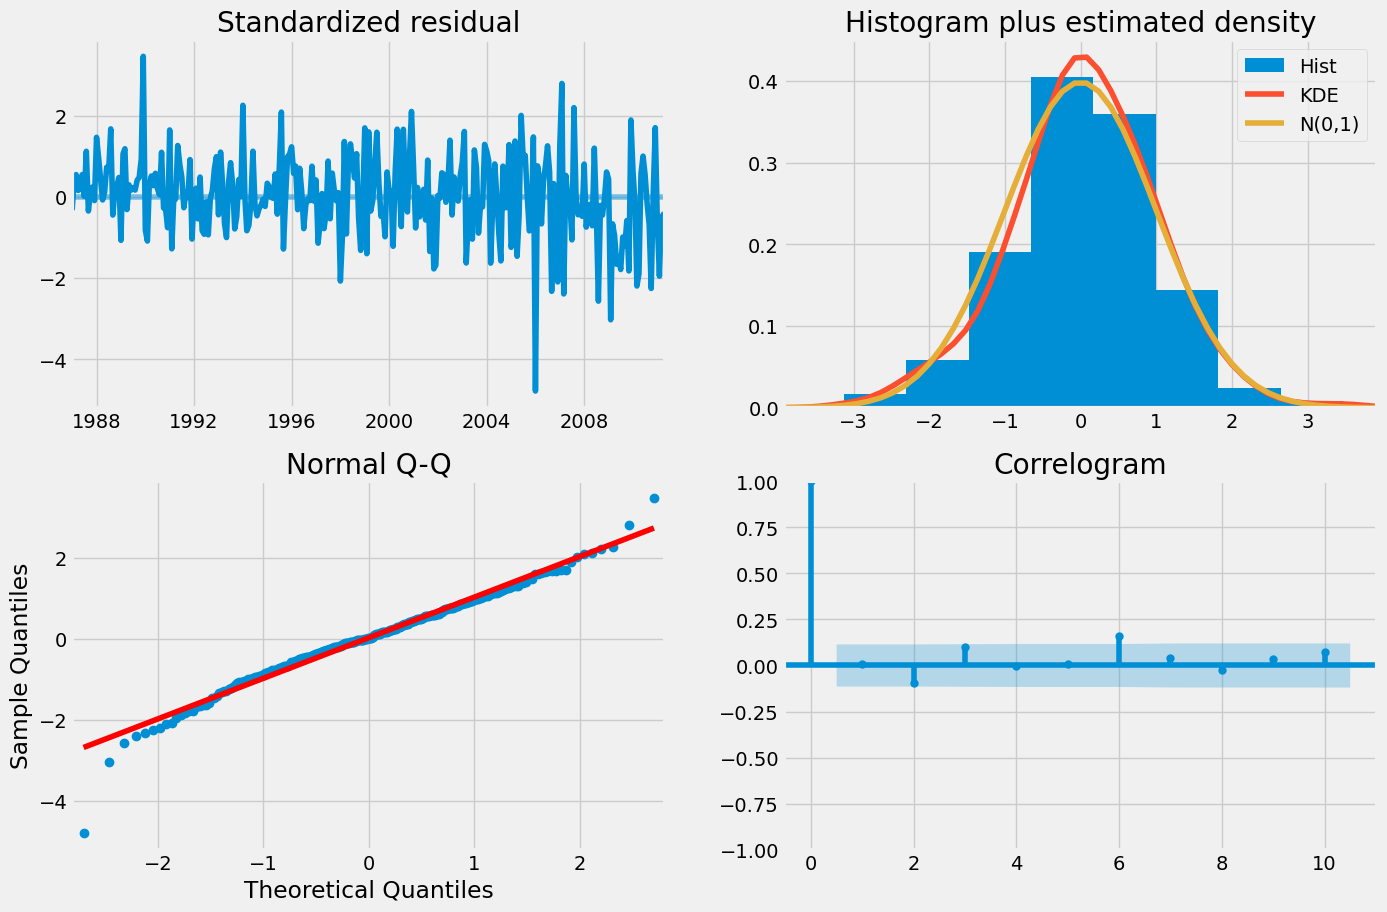

In [44]:
# интерпретация SARIMA модели в виде графиков
auto_sarima_results.plot_diagnostics(figsize=(15,10))
plt.show()

In [45]:
# обучим модель Best model: ARIMA(1,0,0)(0,1,1)[12] intercept
sarima_model= SARIMAX(train["IPG2211A2N"], order= (1,0,0), seasonal_order= (0,1,1,12), freq=train.index.inferred_freq)
sarima_model_fit= sarima_model.fit()

c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [46]:
# сделаем прогнозы на Test данных
start= len(train)
end= len(train) + len(test) -1
pred_sarima= sarima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("SARIMA predictions")


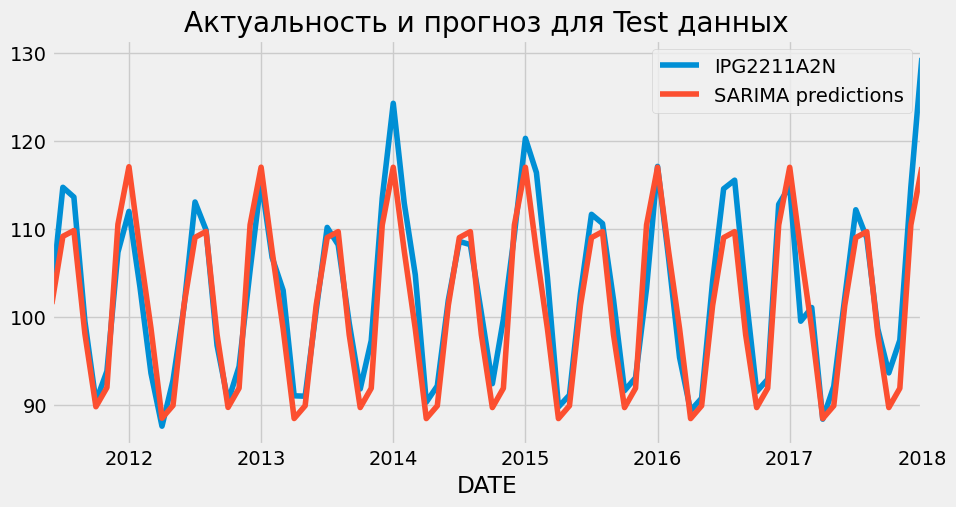

In [47]:
# построим прогноз
title= "Актуальность и прогноз для Test данных"
test["IPG2211A2N"].plot(title= title, legend=True)
pred_sarima.plot(legend=True);

Модель SARIMA намного лучше предсказывает на тестовых данных, чем ARIMA. Сезонные данные вносят значительный вес в построение прогнозирующей модели.

In [48]:
# оценим модель по штрафным баллам
mse_sarima= mean_squared_error(test["IPG2211A2N"],pred_sarima)
rmse_sarima= rmse(test["IPG2211A2N"], pred_sarima)

print(f"RMSE_SARIMA= {rmse_sarima}")
print(f"MSE_SARIMA= {mse_sarima}")

RMSE_SARIMA= 3.7330375734258254
MSE_SARIMA= 13.935569524608976


Как видим *RMSE* значение практически в 3 раза меньше, чем у модели **ARIMA**.

In [49]:
# Использование метода forecast() с параметром full_results=True для получения данных после прогноза
forecast_steps = 30  # Количество шагов для прогнозирования
forecast_results =  sarima_model_fit.forecast(steps=forecast_steps)
 # Этот метод вернет объект с датами и значениями прогноза
forecast_results

2011-06-01    101.454116
2011-07-01    109.131965
2011-08-01    109.792314
2011-09-01     98.064828
2011-10-01     89.767575
2011-11-01     91.949127
2011-12-01    110.496883
2012-01-01    117.044052
2012-02-01    107.502507
2012-03-01     98.676912
2012-04-01     88.459589
2012-05-01     89.913194
2012-06-01    101.318135
2012-07-01    109.013894
2012-08-01    109.689793
2012-09-01     97.975809
2012-10-01     89.690281
2012-11-01     91.882013
2012-12-01    110.438609
2013-01-01    116.993452
2013-02-01    107.458572
2013-03-01     98.638763
2013-04-01     88.426465
2013-05-01     89.884432
2013-06-01    101.293162
2013-07-01    108.992209
2013-08-01    109.670964
2013-09-01     97.959461
2013-10-01     89.676086
2013-11-01     91.869687
Freq: MS, Name: predicted_mean, dtype: float64

## Обучим другие модели 

Выберем следующие алгоритмы для обучения модели:

- LinearRegression
- RandomForestRegressor
- CatBoostRegressor

In [50]:
# Делим на тестовую и тренировочную выборки
X_train = train.drop('IPG2211A2N', axis=1)
y_train = train['IPG2211A2N']

X_test = test.drop('IPG2211A2N', axis=1)
y_test = test['IPG2211A2N']

print('Размер тренировочной выборки (признаки):', X_train.shape)
print('Размер тестовой выборки (признаки):', X_test.shape)
print('Размер тренировочной выборки (целевой признак):', y_train.shape)
print('Размер тестовой выборки (целевой признак):', y_test.shape)

Размер тренировочной выборки (признаки): (305, 4)
Размер тестовой выборки (признаки): (80, 4)
Размер тренировочной выборки (целевой признак): (305,)
Размер тестовой выборки (целевой признак): (80,)


In [51]:
X_train

,12-month-SMA,12-month-Std,difference_1,difference_seasonal
DATE,,,,
1986-01-01,62.232375,5.880632,4.5912,0.8005
1986-02-01,62.008617,5.573367,-5.3188,-2.6851
1986-03-01,61.989608,5.572113,-5.7648,-0.2281
1986-04-01,61.953067,5.605773,-5.1892,-0.4385
1986-05-01,61.994617,5.553706,-1.2192,0.4986
...,...,...,...,...
2011-01-01,102.636167,11.327877,5.1614,0.4714
2011-02-01,102.373025,11.163240,-12.1127,-3.1577
2011-03-01,102.442658,11.137878,-8.2725,0.8356


In [52]:
# Масштабируем признаки
scaler = StandardScaler()
scaler.fit(X_train.iloc[:, 0:]) 

X_train.iloc[:, 0:] = scaler.transform(X_train.iloc[:, 0:])
X_test.iloc[:, 0:] = scaler.transform(X_test.iloc[:, 0:])

X_train.head()

,12-month-SMA,12-month-Std,difference_1,difference_seasonal
DATE,,,,
1986-01-01,-1.899606,-1.037834,0.618089,-0.254507
1986-02-01,-1.917834,-1.248331,-0.736703,-1.375045
1986-03-01,-1.919383,-1.249190,-0.797675,-0.585178
1986-04-01,-1.922359,-1.226131,-0.718985,-0.652816
1986-05-01,-1.918975,-1.261800,-0.176248,-0.351561


**Создадим метрику, с помощью которой будет определяться работа модели - *RMSE_scorer*.**

In [53]:
def RMSE_scorer(model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train)
     
    pred_test = model.predict(X_test)
    
    RMSE_test = root_mean_squared_error(y_test, pred_test)

    print('RMSE модели на тестовой выборке:', RMSE_test)
    
    return RMSE_test

Подбор лучших гиперпараметров осуществим с помощью *RandomizedSearchCV*. Воспользуемся кросс-валидацией для временных рядов *TimeSeriesSplit()*

In [54]:
tscv = TimeSeriesSplit(n_splits=3)

In [55]:
#Функция подбора гиперпараметров моделей
def best_hyper_model(model, parameters_m, X, y):
    
    # подбор лучших гиперпараметров модели с учетом метрики RMSE
    
    grid_m = RandomizedSearchCV(model, parameters_m, cv=tscv, n_jobs=-1, scoring='neg_root_mean_squared_error', random_state=42)
    grid_m.fit(X, y)

    best_params = grid_m.best_params_

    print('Гиперпараметры лучшей модели', best_params)
    
    # обучение модели с лучшими гиперпараметрами
    # функция возвращает модель, гиперпараметры
    
    best_model = model
    best_model.set_params(**best_params) # добавление лучших гиперпараметров

    return best_model, best_params

### Линейная регрессия (LinearRegression)

In [56]:
parameters_LR ={'fit_intercept':[True, False], 
                'copy_X':[True, False]}

In [57]:
model_LR, params_LR = best_hyper_model(
    LinearRegression(), 
    parameters_LR, 
    X_train,
    y_train
)

c:\Program Files\Python312\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Гиперпараметры лучшей модели {'fit_intercept': True, 'copy_X': True}


In [58]:
RMSE_scorer_LR = RMSE_scorer(
    model_LR, X_train, y_train, X_test, y_test
)

RMSE модели на тестовой выборке: 7.95940870460091


### Случайный лес (RandomForestRegressor)

In [59]:
parameters_RFR  = {'max_depth': range(1, 10),
                   'n_estimators': range(1, 41, 10)}

In [60]:
model_RFR, params_RFR = best_hyper_model(
    RandomForestRegressor(random_state=42), 
    parameters_RFR, 
    X_train,
    y_train
)

Гиперпараметры лучшей модели {'n_estimators': 21, 'max_depth': 8}


In [61]:
RMSE_scorer_RFR = RMSE_scorer(
    model_RFR, X_train, y_train, X_test, y_test
)

RMSE модели на тестовой выборке: 8.586329950734523


### CatBoostRegressor

In [62]:
parameters_CBR  = {'iterations': range(10, 110, 20),
                   'depth' : range(5, 11, 2)}

In [63]:
warnings.filterwarnings('ignore')
model_CBR, params_CBR = best_hyper_model(
    CatBoostRegressor(random_state=42, loss_function='RMSE', verbose=0), 
    parameters_CBR, 
    X_train,
    y_train
)

Гиперпараметры лучшей модели {'iterations': 50, 'depth': 5}


In [64]:
RMSE_scorer_CBR = RMSE_scorer(
    model_CBR, X_train, y_train, X_test, y_test
)

RMSE модели на тестовой выборке: 8.898583153291257


### Вывод по обученным моделям

In [65]:
pd.DataFrame(
    {'Параметры': [params_CBR, params_RFR, params_LR], 
     'RMSE': [RMSE_scorer_CBR, RMSE_scorer_RFR, RMSE_scorer_LR]},
    index=['CatBoostRegressor', 'RandomForestRegressor', 'LinearRegression']
)

,Параметры,RMSE
CatBoostRegressor,"{'iterations': 50, 'depth': 5}",8.898583
RandomForestRegressor,"{'n_estimators': 21, 'max_depth': 8}",8.586330
LinearRegression,"{'fit_intercept': True, 'copy_X': True}",7.959409


Наилучшая модель по метрике RMSE: **LinearRegression с гиперпараметрами: {'fit_intercept': True, 'copy_X': True}.**

## Общий вывод

In [66]:
pd.DataFrame(
    {'RMSE': [RMSE_scorer_CBR, RMSE_scorer_RFR, RMSE_scorer_LR, rmse_sarima, rmse_arima]},
    index=['CatBoostRegressor', 'RandomForestRegressor', 'LinearRegression', 'SARIMA', 'ARIMA']
)

,RMSE
CatBoostRegressor,8.898583
RandomForestRegressor,8.586330
LinearRegression,7.959409
SARIMA,3.733038
ARIMA,9.822132


Модель *SARIMA* на метрике *RMSE* показала наилучшее качество. Есть несколько возможностей улучшить метрики для линейных, ансамблевых и бустинговых моделей:

1. Добавить дополнительные признаки для обучения.
2. Улучшить сетку для подбора гиперпараметров.